# Imports & helpers


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone


In [2]:
BASE = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

def soql_get(params, app_token=None):
    headers = {}
    if app_token:
        headers["X-App-Token"] = app_token
    r = requests.get(BASE, params=params, headers=headers, timeout=60)
    if r.status_code != 200:
        print("Status:", r.status_code)
        print(r.text[:1000])
    r.raise_for_status()
    return r.json()

def socrata_dt(dt):
    return dt.astimezone(timezone.utc).strftime("%Y-%m-%dT%H:%M:%S.000")

now = datetime.now(timezone.utc)
start_this = now - timedelta(days=7)
start_last = now - timedelta(days=14)
end_last = now - timedelta(days=7)

params_this = {
    "$select": "complaint_type, count(*) as n",
    "$where": f"created_date >= '{socrata_dt(start_this)}'",
    "$group": "complaint_type",
    "$order": "count(*) DESC",
    "$limit": 50
}

params_last = {
    "$select": "complaint_type, count(*) as n",
    "$where": f"created_date >= '{socrata_dt(start_last)}' AND created_date < '{socrata_dt(end_last)}'",
    "$group": "complaint_type",
    "$order": "count(*) DESC",
    "$limit": 200
}

this_week = pd.DataFrame(soql_get(params_this))
last_week = pd.DataFrame(soql_get(params_last))

this_week["n"] = this_week["n"].astype(int)

last_week["n"] = last_week["n"].astype(int)

comp = (
    this_week.rename(columns={"n": "n_this"})
    .merge(last_week.rename(columns={"n": "n_last"}), on="complaint_type", how="left")
    .fillna({"n_last": 0})
)

comp["n_last"] = comp["n_last"].astype(int)
comp["delta"] = comp["n_this"] - comp["n_last"]


# Pull data + build comp

In [3]:
comp.head()


,complaint_type,n_this,n_last,delta
0,HEAT/HOT WATER,22551,15896,6655
1,Snow or Ice,12236,2745,9491
2,Illegal Parking,7770,10720,-2950
3,Noise - Residential,5871,6381,-510
4,Blocked Driveway,2938,3272,-334


# Top 20 complaint types (bar chart)

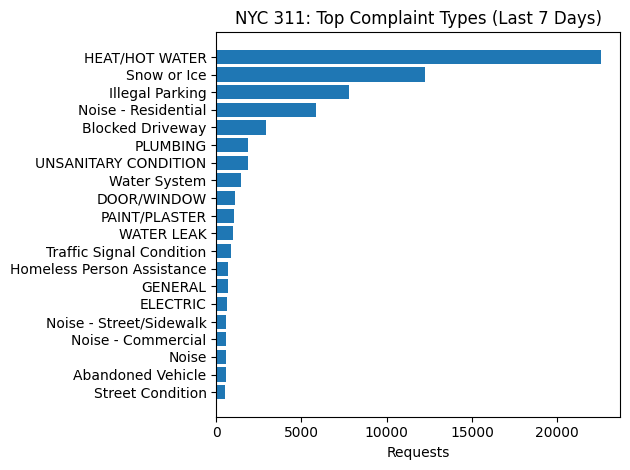

In [4]:
top20 = comp.sort_values("n_this", ascending=False).head(20)

plt.figure()
plt.barh(top20["complaint_type"][::-1], top20["n_this"][::-1])
plt.title("NYC 311: Top Complaint Types (Last 7 Days)")
plt.xlabel("Requests")
plt.ylabel("")
plt.tight_layout()
plt.show()


# Biggest movers vs last week

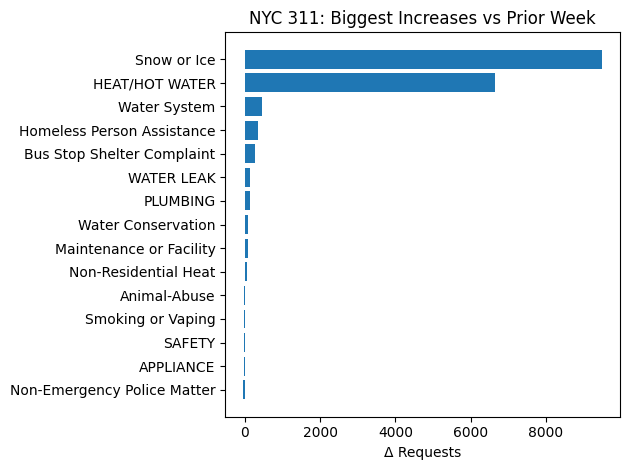

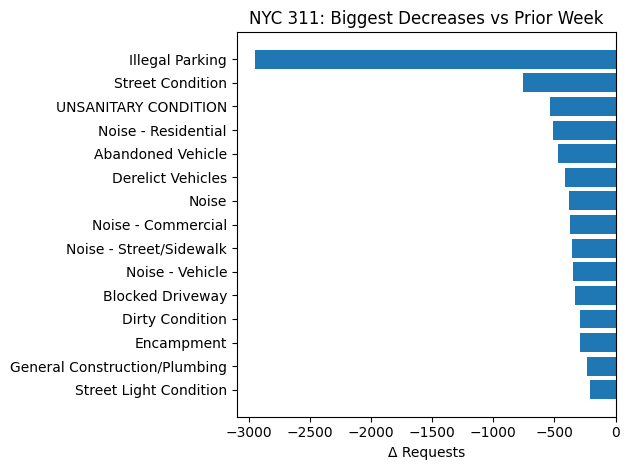

In [5]:
up = comp.sort_values("delta", ascending=False).head(15)
down = comp.sort_values("delta", ascending=True).head(15)

plt.figure()
plt.barh(up["complaint_type"][::-1], up["delta"][::-1])
plt.title("NYC 311: Biggest Increases vs Prior Week")
plt.xlabel("Δ Requests")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(down["complaint_type"][::-1], down["delta"][::-1])
plt.title("NYC 311: Biggest Decreases vs Prior Week")
plt.xlabel("Δ Requests")
plt.tight_layout()
plt.show()


# 30-day trend (the “alive” part)

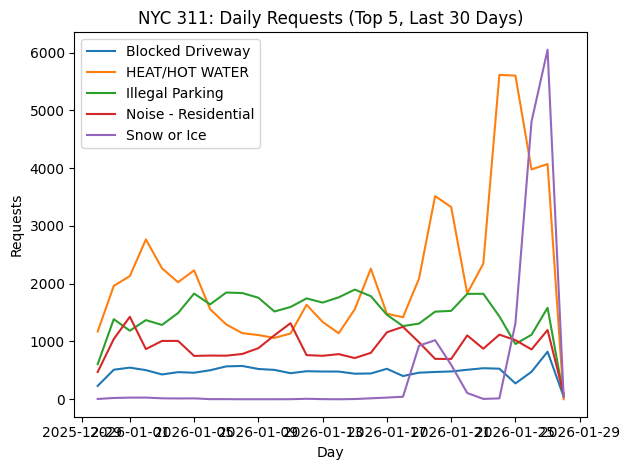

In [6]:
now = datetime.now(timezone.utc)
start_30 = now - timedelta(days=30)

top5 = comp.sort_values("n_this", ascending=False).head(5)["complaint_type"].tolist()

def escape_soql_string(s: str) -> str:
    return s.replace("'", "''")

where_types = " OR ".join([f"complaint_type = '{escape_soql_string(t)}'" for t in top5])

params_trend = {
    "$select": "date_trunc_ymd(created_date) as day, complaint_type, count(*) as n",
    "$where": f"created_date >= '{socrata_dt(start_30)}' AND ({where_types})",
    "$group": "day, complaint_type",
    "$order": "day ASC",
    "$limit": 50000
}

trend = pd.DataFrame(soql_get(params_trend))
trend["n"] = trend["n"].astype(int)
trend["day"] = pd.to_datetime(trend["day"])

pivot = (trend.pivot_table(index="day", columns="complaint_type", values="n", aggfunc="sum")
              .fillna(0)
              .sort_index())

plt.figure()
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=col)
plt.title("NYC 311: Daily Requests (Top 5, Last 30 Days)")
plt.xlabel("Day")
plt.ylabel("Requests")
plt.legend()
plt.tight_layout()
plt.show()
